# PESTPP-GLM Part 2

In this notebook, we will actually run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF. We will reuse the jacobian we used for FOSM to save runs

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_csiro/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 10

In [3]:
t_d = "template"
m_d = "master_glm_run"

In [4]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
pp_prsity0,pp_prsity0,log,32,0,0.176091,-0.30103,0.11928
strk,strk,log,40,0,2,-2,1
pp_sy1,pp_sy1,log,32,0,0.243038,-0.60206,0.211275
cn_prsity8,cn_prsity8,log,1,0,0.176091,-0.30103,0.11928
gr_hk3,gr_hk3,fixed,705,1,10,0.1,2.475
cn_rech4,cn_rech4,log,1,0,0.0413927,-0.0457575,0.0217875
pp_ss2,pp_ss2,log,32,0,1,-1,0.5
gr_rech2,gr_rech2,fixed,705,1,1.1,0.9,0.05
gr_hk4,gr_hk4,fixed,705,1,10,0.1,2.475
pp_ss1,pp_ss1,log,32,0,1,-1,0.5


Load and extract the portion of the prior we need for FOSM

In [5]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))
cov.get(pst.adj_par_names).to_ascii(os.path.join(t_d,"glm_prior.cov"))

new binary format detected...


 set some control options

In [6]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "glm_prior.cov"
pst.pestpp_options["base_jacobian"] = "freyberg_reuse.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [7]:
shutil.copy2(os.path.join("master_glm","freyberg_pp.jcb"),os.path.join(t_d,"freyberg_reuse.jcb"))

'template/freyberg_reuse.jcb'

In [8]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=num_workers,slave_root=".",
                           master_dir=m_d)

In [9]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
38     20.252546
15     21.726850
22     28.468621
5      40.663327
0      44.486239
1      46.335243
31     48.602332
41     50.931394
26     52.593058
6      53.499512
12     76.266670
18     81.114914
48     83.017110
2      88.304519
43     88.344489
10     89.887594
23     94.466519
24    105.041303
37    112.244877
49    116.235441
dtype: float64

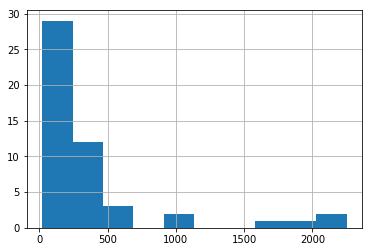

In [10]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [11]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [12]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,359.20800,-1695.65000,-258.8230,-489.5030,217.519000,-924.5410,-54.4663
fa_hw_19801229,-500.5320,589.30900,-1679.15000,678.0860,149.9420,525.460000,-900.9780,1200.8600
fa_tw_19791230,-453.0330,414.90700,-1282.85000,376.7810,-413.4270,143.861000,-701.1500,-125.7050
fa_tw_19801229,-11.2061,610.23700,-1231.68000,1209.2700,28.3350,467.609000,-906.8820,963.5520
hds_00_013_002_000,39.6102,2.76268,34.08490,45.1356,37.7875,0.299594,37.1883,38.3867
hds_00_013_002_001,39.0079,2.91274,33.18250,44.8334,37.1447,0.410993,36.3227,37.9667
part_status,2.0000,0.00000,2.00000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,458.56200,-9.42189,1824.8300,890.3290,336.786000,216.7570,1563.9000


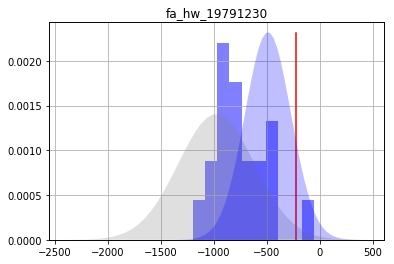

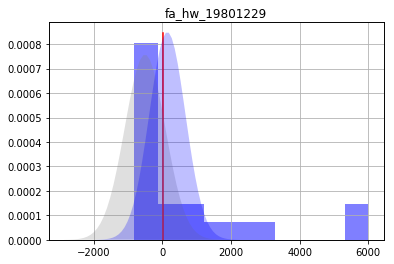

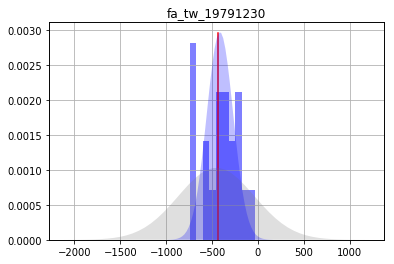

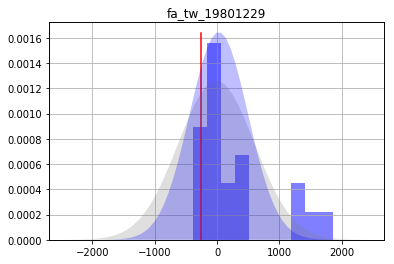

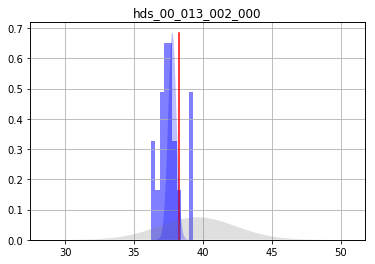

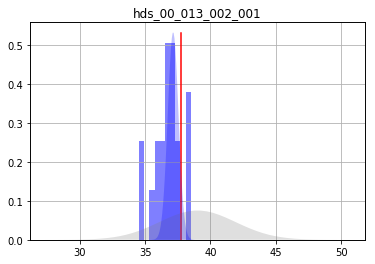

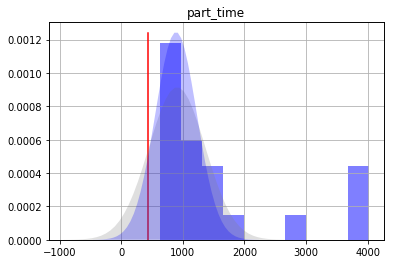

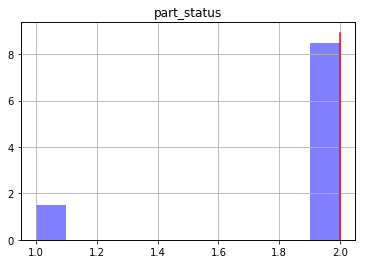

In [13]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [14]:
cov = pyemu.Cov.from_ascii(os.path.join(t_d,"glm_prior.cov"))

In [15]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [16]:
pst.prior_information.sort_values(by="weight",ascending=False).head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_10,1.0 * log(dc0000390006) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_10,0.904837
pcc_43,1.0 * log(dc0000390012) - 1.0 * log(dc0000390013) = 0.0,regul_cc,pcc_43,0.904837
pcc_40,1.0 * log(dc0000390011) - 1.0 * log(dc0000390012) = 0.0,regul_cc,pcc_40,0.904837
pcc_36,1.0 * log(dc0000390010) - 1.0 * log(dc0000390011) = 0.0,regul_cc,pcc_36,0.904837


In [17]:
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [18]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=num_workers,slave_root=".",
                           master_dir=m_d)

In [19]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
38     28.033506
15     31.285081
43     37.305393
22     37.328963
0      38.684235
35     40.693600
31     43.121395
1      44.106285
5      49.328534
12     50.396984
48     55.666585
18     59.618114
46     62.342003
42     64.014081
44     66.322496
26     69.195631
6      79.017769
41     97.523164
37    100.319933
2     108.258736
dtype: float64

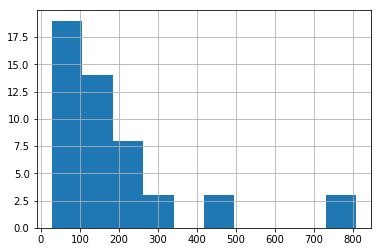

In [20]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [21]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [22]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,359.20800,-1695.65000,-258.8230,-679.2560,223.932000,-1127.1200,-231.3920
fa_hw_19801229,-500.5320,589.30900,-1679.15000,678.0860,-184.0380,531.386000,-1246.8100,878.7330
fa_tw_19791230,-453.0330,414.90700,-1282.85000,376.7810,-387.6090,145.300000,-678.2080,-97.0099
fa_tw_19801229,-11.2061,610.23700,-1231.68000,1209.2700,-5.3833,468.053000,-941.4900,930.7230
hds_00_013_002_000,39.6102,2.76268,34.08490,45.1356,37.8504,0.299934,37.2506,38.4503
hds_00_013_002_001,39.0079,2.91274,33.18250,44.8334,37.4613,0.411130,36.6390,38.2836
part_status,2.0000,0.00000,2.00000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,458.56200,-9.42189,1824.8300,1034.0000,337.515000,358.9680,1709.0300


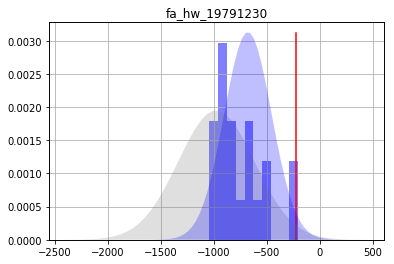

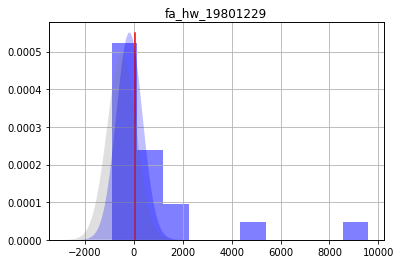

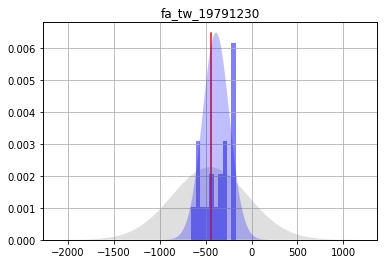

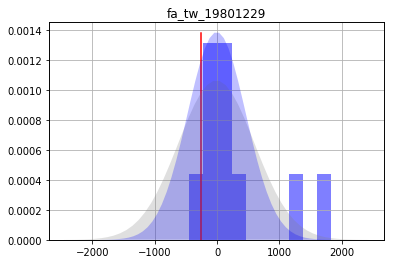

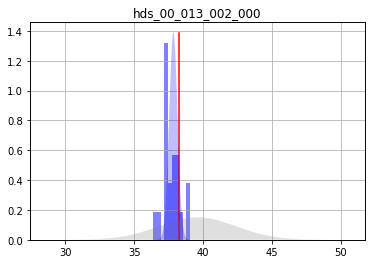

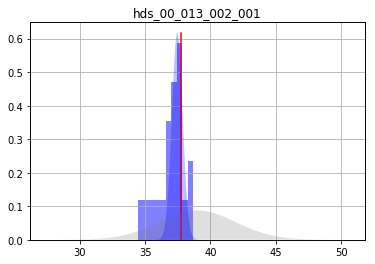

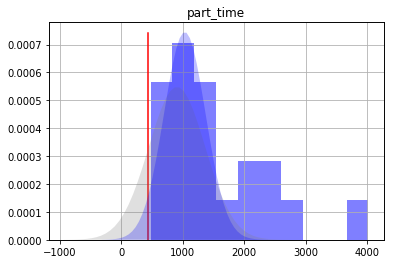

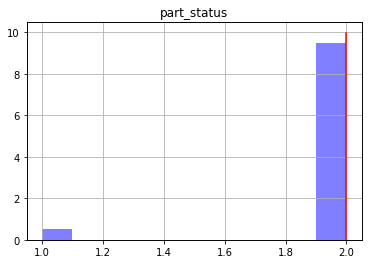

In [23]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()